In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline

In [3]:
df = pd.read_csv('data/loan_data.csv')

In [4]:
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [5]:
# Make all string columns lowercase and replace spaces with underscores
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')

In [6]:
df.isnull().sum()


person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [7]:
df.nunique()

person_age                           60
person_gender                         2
person_education                      5
person_income                     33989
person_emp_exp                       63
person_home_ownership                 4
loan_amnt                          4483
loan_intent                           6
loan_int_rate                      1302
loan_percent_income                  64
cb_person_cred_hist_length           29
credit_score                        340
previous_loan_defaults_on_file        2
loan_status                           2
dtype: int64

In [8]:
df.rename(columns={'loan_status': 'y'}, inplace=True)

In [9]:
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,y
0,22.0,female,master,71948.0,0,rent,35000.0,personal,16.02,0.49,3.0,561,no,1
1,21.0,female,high_school,12282.0,0,own,1000.0,education,11.14,0.08,2.0,504,yes,0
2,25.0,female,high_school,12438.0,3,mortgage,5500.0,medical,12.87,0.44,3.0,635,no,1
3,23.0,female,bachelor,79753.0,0,rent,35000.0,medical,15.23,0.44,2.0,675,no,1
4,24.0,male,master,66135.0,1,rent,35000.0,medical,14.27,0.53,4.0,586,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,associate,47971.0,6,rent,15000.0,medical,15.66,0.31,3.0,645,no,1
44996,37.0,female,associate,65800.0,17,rent,9000.0,homeimprovement,14.07,0.14,11.0,621,no,1
44997,33.0,male,associate,56942.0,7,rent,2771.0,debtconsolidation,10.02,0.05,10.0,668,no,1
44998,29.0,male,bachelor,33164.0,4,rent,12000.0,education,13.23,0.36,6.0,604,no,1


In [10]:
numerical = ["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]
categorical = ["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"]

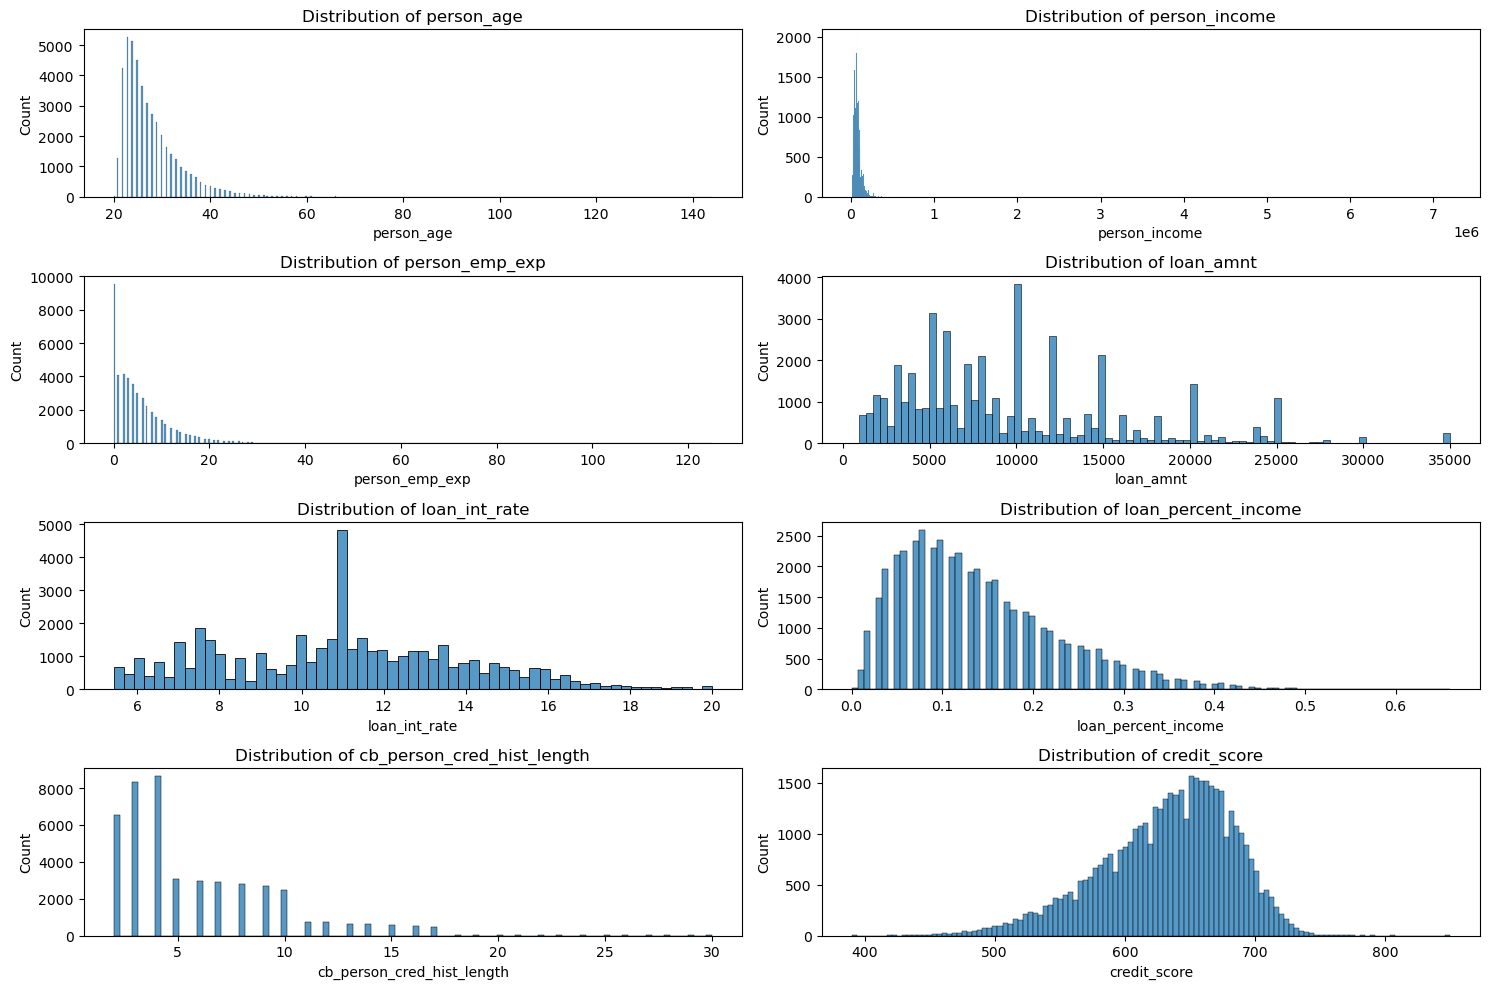

In [11]:
# Create histograms for all numerical variables
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical):
    sns.histplot(data=df, x=col, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

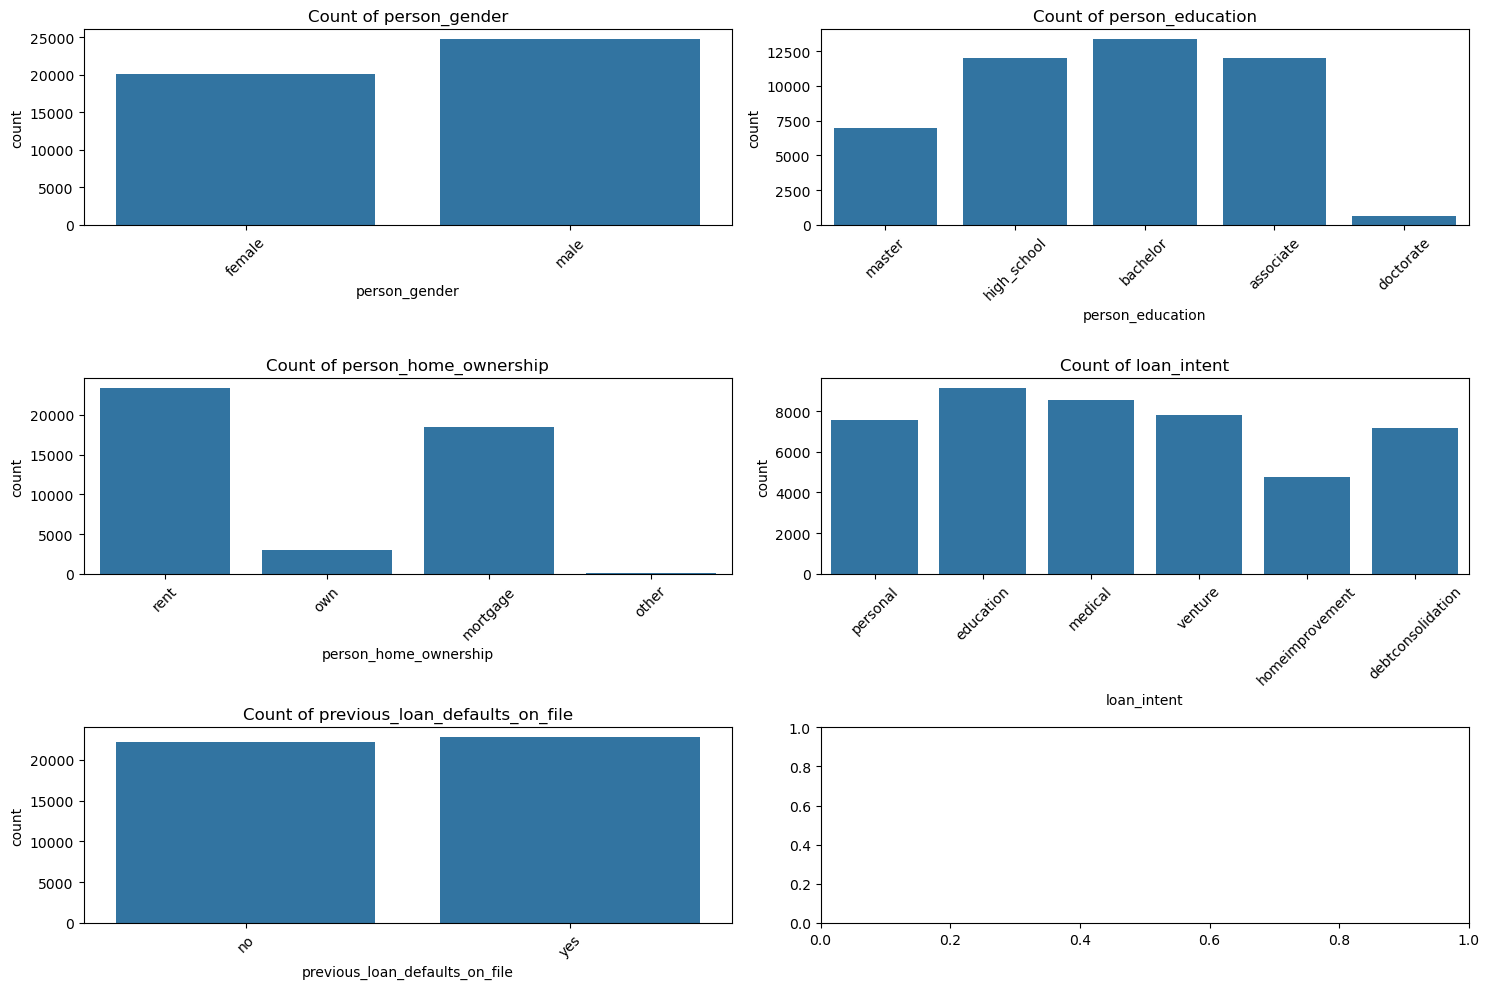

In [12]:
# Create countplots for categorical variables
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical):
    sns.countplot(data=df, x=col, ax=axes[idx])
    axes[idx].set_title(f'Count of {col}')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

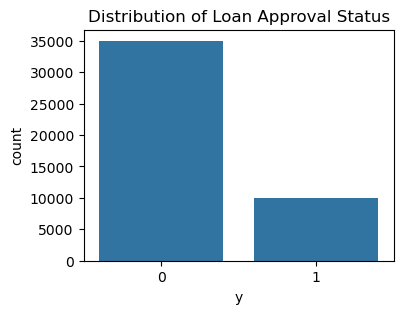

Class distribution:
y
0    0.777778
1    0.222222
Name: proportion, dtype: float64


In [13]:
# Distribution of target variable
plt.figure(figsize=(4, 3))
sns.countplot(data=df, x='y')
plt.title('Distribution of Loan Approval Status')
plt.show()

# Calculate class imbalance
print("Class distribution:")
print(df['y'].value_counts(normalize=True))

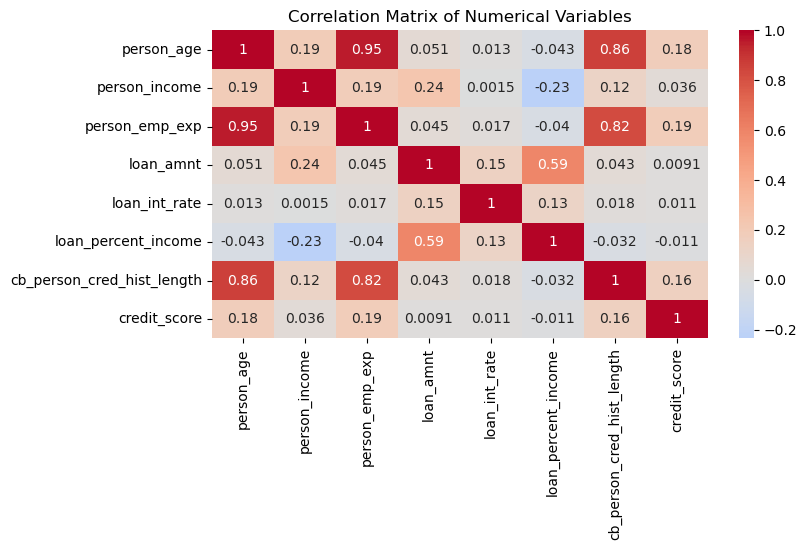

In [14]:
# Create correlation matrix heatmap
plt.figure(figsize=(8, 4))
correlation_matrix = df[numerical].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [15]:
# Remove highly correlated features
df = df.drop(columns=['person_emp_exp', 'cb_person_cred_hist_length'])
numerical.remove('person_emp_exp')
numerical.remove('cb_person_cred_hist_length')

In [16]:
# Split the data into training, validation, and test sets
seed = 42
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)
print(len(df_train), len(df_val), len(df_test))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

27000 9000 9000


In [17]:
# Check feature importance of numerical variables.
scores = []
for c in numerical:
  auc = roc_auc_score(y_train, df_train[c])
  if auc < 0.5:
    auc = roc_auc_score(y_train, -df_train[c])
  scores.append((c, auc))

scores.sort(key=lambda x: x[1], reverse=True)
for c, score in scores:
  print(c, score)


loan_percent_income 0.7293006224333364
loan_int_rate 0.7179735853860287
person_income 0.6872535577261774
loan_amnt 0.5656055346932246
person_age 0.522210015656245
credit_score 0.5027791109241962


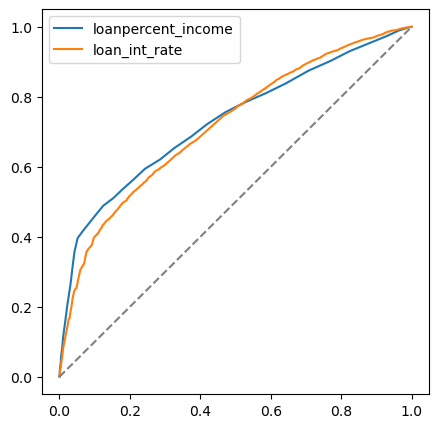

In [18]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train["loan_percent_income"])
plt.plot(fpr, tpr, label='loanpercent_income')

fpr, tpr, _ = roc_curve(y_train, df_train["loan_int_rate"])
plt.plot(fpr, tpr, label='loan_int_rate')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [19]:
def mutual_info_y_score(df_column):
  return mutual_info_score(df_column, y_train)

mutual_info_scores = df_train[categorical].apply(mutual_info_y_score)
mutual_info_scores.sort_values(ascending=False).to_frame(name='Mutual Information')


,Mutual Information
previous_loan_defaults_on_file,1.892079e-01
person_home_ownership,3.611889e-02
loan_intent,1.074586e-02
person_education,3.983651e-05
person_gender,8.980920e-07


In [20]:
def train(df_train, y_train, C=1.0):
  dv = DictVectorizer(sparse=False)

  train_dict = df_train.to_dict(orient='records')
  X_train = dv.fit_transform(train_dict)

  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
  model.fit(X_train, y_train)

  return model, dv

def predict(model, df_val, dv):
  val_dict = df_val.to_dict(orient='records')
  X_val = dv.transform(val_dict)
  y_pred = model.predict_proba(X_val)[:,1]
  return y_pred

In [21]:
# Training
model, dv = train(df_train, y_train)

In [22]:
# Validation
y_pred = predict(model, df_val, dv)
roc_auc_score(y_val, y_pred)

0.7832017368639193

In [23]:
def PR_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores


In [24]:
df_scores = PR_dataframe(y_val, y_pred)
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,2007,6993,0,0,0.223000,1.000000
1,0.01,1983,6738,24,255,0.227382,0.988042
2,0.02,1966,6549,41,444,0.230887,0.979571
3,0.03,1960,6402,47,591,0.234394,0.976582
4,0.04,1955,6218,52,775,0.239202,0.974091
...,...,...,...,...,...,...,...
96,0.96,0,0,2007,6993,NaN,0.000000
97,0.97,0,0,2007,6993,NaN,0.000000
98,0.98,0,0,2007,6993,NaN,0.000000
99,0.99,0,0,2007,6993,NaN,0.000000


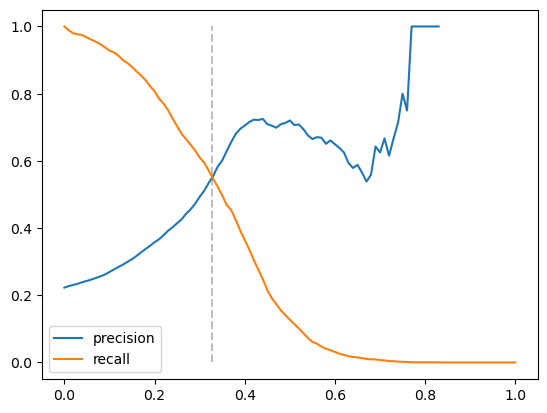

In [25]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.vlines(0.327, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [26]:
df_scores['f1'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])

In [27]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.320000
tp           1147.000000
fp           1000.000000
fn            860.000000
tn           5993.000000
precision       0.534234
recall          0.571500
f1              0.552239
Name: 32, dtype: float64

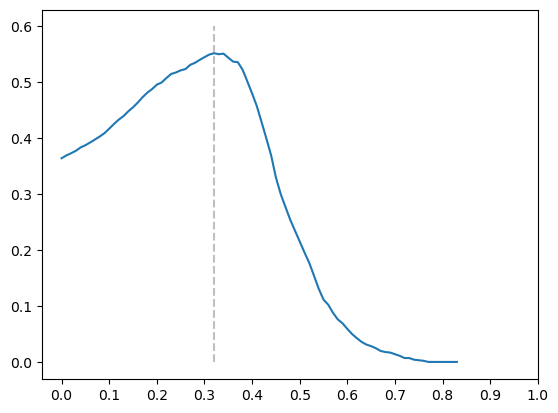

In [28]:
plt.plot(df_scores.threshold, df_scores['f1'])
plt.vlines(0.32, 0.0, 0.6, color='grey', linestyle='--', alpha=0.5)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.y.values
  y_val = df_val.y.values

  model, dv = train(df_train, y_train)
  y_pred = predict(model, df_val, dv)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

print(np.mean(scores), np.std(scores))

0.8877721036568655 0.09552117783264757


In [30]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for C in C_values:
  kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
  scores = []

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    model, dv = train(df_train, y_train, C=C)
    y_pred = predict(model, df_val, dv)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

  print(f'C: {C}, mean score: {np.mean(scores)}, std: {np.std(scores)}')

C: 0.0001, mean score: 0.848360238728142, std: 0.062201594819698884
C: 0.001, mean score: 0.8866344521174536, std: 0.09413266747614422
C: 0.01, mean score: 0.896955561743414, std: 0.10249926195472064
C: 0.1, mean score: 0.8962178980228531, std: 0.10249314432026031
C: 1, mean score: 0.8877721036568655, std: 0.09552117783264757
C: 10, mean score: 0.8877986022057731, std: 0.09553745830958946
C: 100, mean score: 0.8959090899047274, std: 0.10218754145849776


In [31]:
# Training the final model with the best C value of 0.01
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.y.values
  y_val = df_val.y.values

  model, dv = train(df_train, y_train, C=0.01)
  y_pred = predict(model, df_val, dv)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

print(np.mean(scores), np.std(scores))


0.896955561743414 0.10249926195472064


In [32]:
# Save the model
model_name = 'model.bin'
with open(model_name, 'wb') as f_out:
  pickle.dump((dv, model), f_out)

print(f'Model is saved to {model_name}')

Model is saved to model.bin
